In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
DICOM_PATH = "ADD YOUR DICOM PATH HERE"

In [13]:
import os, glob
print(" listing under MyDrive (edit the glob to your folder):")
for p in glob.glob("/content/drive/MyDrive/**/*", recursive=True)[:20]:
    print(p)

 listing under MyDrive (edit the glob to your folder):
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Echocardiography
/content/drive/MyDrive/Colab Notebooks/Inference Script
/content/drive/MyDrive/Echocardiography/echo-sample-01-deidentified.dcm


In [14]:
!pip -q install pydicom pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg gdcm opencv-python numpy pillow
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install pydicom pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg gdcm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 74.4 MB/s eta 0:00:00


In [15]:
import numpy as np
import torch
import pydicom
from pydicom.pixels import convert_color_space
from pydicom.pixels import apply_voi_lut
import cv2
from typing import Tuple

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
CLIP_LEN = 16    # PanEcho commonly uses 16-frame clips
INPUT_SIZE = 224
print("Device:", DEVICE)
print("DICOM path:", DICOM_PATH)

Device: cpu
DICOM path: /content/drive/MyDrive/Echocardiography/echo-sample-01-deidentified.dcm


In [17]:
def _normalize_to_uint8(arr: np.ndarray) -> np.ndarray:
    """Min-max normalize to [0,255] uint8 (per frame if 3D)."""
    arr = arr.astype(np.float32)
    if arr.ndim == 2:
        mn, mx = float(arr.min()), float(arr.max())
        if mx > mn:
            arr = (arr - mn) / (mx - mn)
        else:
            arr = np.zeros_like(arr, dtype=np.float32)
        return (arr * 255.0).clip(0, 255).astype(np.uint8)
    elif arr.ndim == 3:
        frames_u8 = []
        for f in arr:
            mn, mx = float(f.min()), float(f.max())
            if mx > mn:
                f = (f - mn) / (mx - mn)
            else:
                f = np.zeros_like(f, dtype=np.float32)
            frames_u8.append((f * 255.0).clip(0, 255).astype(np.uint8))
        return np.stack(frames_u8, 0)
    else:
        raise ValueError(f"Unexpected array shape: {arr.shape}")

def _ensure_grayscale(frames: np.ndarray) -> np.ndarray:

    if frames.ndim == 2:
        return frames[None, ...]
    if frames.ndim == 3 and frames.shape[-1] == 3:
        rgb = frames
        gray = (0.299*rgb[...,0] + 0.587*rgb[...,1] + 0.114*rgb[...,2]).astype(rgb.dtype)
        return gray[None, ...] if gray.ndim == 2 else gray
    if frames.ndim == 4 and frames.shape[-1] == 3:
        rgb = frames
        gray = (0.299*rgb[...,0] + 0.587*rgb[...,1] + 0.114*rgb[...,2]).astype(rgb.dtype)
        return gray
    return frames  # assume already (T,H,W)

def read_echo_dicom_frames(dcm_path: str) -> np.ndarray:
    """

    Handles compressed transfer syntaxes via pylibjpeg/GDCM; VOI LUT; slope/intercept;
    YBR/RGB conversion; MONOCHROME1 inversion.
    """
    ds = pydicom.dcmread(dcm_path, force=True)

    # Accessing pixel_array triggers decompression if needed
    px = ds.pixel_array

    # If color space is YBR_* convert to RGB for consistent grayscale conversion
    photometric = getattr(ds, "PhotometricInterpretation", None)
    if px.ndim >= 3 and px.shape[-1] == 3 and photometric and photometric != "RGB":
        try:
            px = convert_color_space(px, photometric, "RGB")
        except Exception:
            pass

    # Apply VOI LUT if present (common in medical DICOMs)
    try:
        px = apply_voi_lut(px, ds)
    except Exception:
        pass

    # Apply rescale (often NOP for ultrasound, but safe)
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    intercept = float(getattr(ds, "RescaleIntercept", 0.0))
    if slope != 1.0 or intercept != 0.0:
        px = px.astype(np.float32) * slope + intercept

    frames = _ensure_grayscale(px)

    # Invert MONOCHROME1 polarity so bright stays bright
    if getattr(ds, "PhotometricInterpretation", "") == "MONOCHROME1":
        if np.issubdtype(frames.dtype, np.integer):
            maxv = np.iinfo(frames.dtype).max
        else:
            maxv = float(frames.max()) if frames.size else 0.0
        frames = (maxv - frames)

    return _normalize_to_uint8(frames)  # (T,H,W) uint8



In [18]:
def uniform_sample_indices(n_total: int, n_target: int) -> np.ndarray:

    if n_total <= n_target:
        return np.arange(n_total, dtype=np.int32)
    step = n_total / float(n_target)
    return np.array([int(i*step + step/2.0) for i in range(n_target)], dtype=np.int32)

def frames_to_panecho_tensor(
    frames_uint8: np.ndarray,
    clip_len: int = CLIP_LEN,
    size: int = INPUT_SIZE,
    imagenet_mean: np.ndarray = IMAGENET_MEAN,
    imagenet_std:  np.ndarray = IMAGENET_STD
) -> torch.Tensor:

    assert frames_uint8.ndim == 3, f"Expected (T,H,W), got {frames_uint8.shape}"
    idx = uniform_sample_indices(frames_uint8.shape[0], clip_len)
    sampled = frames_uint8[idx]  # (t,H,W)

    # Resize to 224x224
    resized = np.stack([cv2.resize(f, (size, size), interpolation=cv2.INTER_AREA) for f in sampled], axis=0)

    x = resized.astype(np.float32) / 255.0
    x = np.stack([x, x, x], axis=1)  # (t,3,224,224)
    x = (x - imagenet_mean[None, :, None, None]) / imagenet_std[None, :, None, None]

    # pad/trim to clip_len
    t = x.shape[0]
    if t < clip_len:
        pad = np.repeat(x[-1:, ...], clip_len - t, axis=0)
        x = np.concatenate([x, pad], axis=0)
    elif t > clip_len:
        x = x[:clip_len]

    x = np.transpose(x, (1,0,2,3)) # (3,T,224,224)
    x = np.expand_dims(x, 0)
    return torch.from_numpy(x).float()

In [19]:
model = torch.hub.load('CarDS-Yale/PanEcho', 'PanEcho', force_reload=False, clip_len=CLIP_LEN).to(DEVICE).eval()
print("PanEcho loaded from GitHub via torch.hub.")

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/CarDS-Yale/PanEcho/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:02<00:00, 43.1MB/s]


Downloading: "https://github.com/CarDS-Yale/PanEcho/releases/download/v1.0/panecho.pt" to /root/.cache/torch/hub/checkpoints/panecho.pt
PanEcho loaded from GitHub via torch.hub.


In [7]:
import os
import time
from typing import Dict, Any

def _standardize(outputs):
    # Placeholder for standardization logic
    return outputs

def _get_model_and_device(clip_len):
    # Placeholder for getting model and device
    return model, DEVICE

def predict_panecho(
    dicom_file_path: str,
    clip_len: int = CLIP_LEN,
    size: int = INPUT_SIZE,
    include_meta: bool = True,
) -> Dict[str, Any]:

    t0 = time.time()

    # --- data loading and preprocessing
    frames = read_echo_dicom_frames(dicom_file_path)              # (T,H,W) uint8
    x = frames_to_panecho_tensor(frames, clip_len=clip_len, size=size)  # (1,3,T,224,224)

    # --- prediction
    model, device = _get_model_and_device(clip_len=clip_len)
    x = x.to(device)
    with torch.no_grad():
        outputs = model(x)

    # --- postprocessing
    std = _standardize(outputs)

    result: Dict[str, Any] = {}
    if include_meta:
        result.update({
            "dicom_file": os.path.basename(dicom_file_path),
            "clip_len": int(clip_len),
            "input_size": int(size),
            "device": str(device),
            "inference_ms": int((time.time() - t0) * 1000),
        })
    result.update(std)
    return result

In [23]:
# If your LV dysfunction head uses [normal, dysfunction], keep = 1; flip to 0 if reversed
DYSFUNC_INDEX = 1

def _standardize(outputs):
    """
    CSV-friendly standardization:
      - EF/LVEF  -> numeric scalar (e.g., 64.0 instead of [[[64]]])
      - LV Dysfunction -> include BOTH:
            LV_Dysfunction_Prob (0..1), LV_Normal_Prob (0..1 = 1 - dysfunction),
            LV_Dysfunction_Label ('dysfunction'|'normal'),
            LV_Normal_Label ('normal'|'dysfunction')
      - Other squeezable scalars are kept as-is.
    """
    import numpy as np
    import torch

    def _to_numpy(x):
        if torch.is_tensor(x):
            return x.detach().cpu().numpy()
        return np.asarray(x)

    def _squeeze_scalar(x):
        """[[[64]]] -> 64 (Python int/float); leaves non-scalars as arrays."""
        arr = _to_numpy(x)
        while hasattr(arr, "shape") and arr.shape != () and all(d == 1 for d in arr.shape):
            arr = arr.reshape(())
        if np.ndim(arr) == 0:
            val = arr.item()
            if isinstance(val, (np.floating, np.float32, np.float64)): return float(val)
            if isinstance(val, (np.integer,  np.int32,   np.int64  )): return int(val)
            return val
        return arr

    def _sigmoid(z: float) -> float:
        z = float(z)
        return 1.0 / (1.0 + np.exp(-z))

    def _softmax(vec: np.ndarray) -> np.ndarray:
        v = np.array(vec, dtype=np.float64)
        v -= v.max()
        e = np.exp(v)
        return e / (e.sum() + 1e-12)

    out = {}

    if isinstance(outputs, dict):
        for k, v in outputs.items():
            kl = k.lower()

            # ---- EF / LVEF (flatten to scalar)
            if "lvef" in kl or kl == "ef" or "ejection" in kl:
                val = _squeeze_scalar(v)
                try:
                    out["EF"] = float(val)
                except Exception:
                    arr = _to_numpy(v).squeeze()
                    out["EF"] = float(arr.flat[0])

            # ---- LV Dysfunction (add normal too)
            elif ("lv" in kl) and ("dys" in kl or "dysfunction" in kl or "function" in kl):
                a = _to_numpy(v).squeeze()

                dys_prob = None
                normal_prob = None

                if a.ndim == 0:
                    # single logit for dysfunction
                    dys_prob = _sigmoid(a)
                    normal_prob = 1.0 - dys_prob

                elif a.ndim == 1 and a.shape[0] == 2:
                    # 2-class vector (normal vs dysfunction)
                    probs = _softmax(a)
                    dys_prob = float(probs[DYSFUNC_INDEX])
                    normal_prob = float(probs[1 - DYSFUNC_INDEX])

                elif a.ndim == 1 and a.shape[0] == 1:
                    # single-logit vector for dysfunction
                    dys_prob = _sigmoid(a[0])
                    normal_prob = 1.0 - dys_prob

                if dys_prob is not None:
                    out["LV_Dysfunction_Prob"] = float(dys_prob)
                    out["LV_Dysfunction_Label"] = "dysfunction" if dys_prob >= 0.5 else "normal"
                if normal_prob is not None:
                    out["LV_Normal_Prob"] = float(normal_prob)
                    out["LV_Normal_Label"] = "normal" if normal_prob >= 0.5 else "dysfunction"

            else:
                # keep other simple scalars
                val = _squeeze_scalar(v)
                if isinstance(val, (int, float, bool, str)):
                    out[k] = val

    else:
        # non-dict fallback
        val = _squeeze_scalar(outputs)
        if isinstance(val, (int, float, bool, str)):
            out["output"] = val

    return out


In [21]:
res = predict_panecho(DICOM_PATH)
# Convert tensor values to float for JSON serialization
for key, value in res.items():
    if isinstance(value, torch.Tensor):
        res[key] = value.squeeze().tolist() if value.numel() > 1 else value.item()

import json; print(json.dumps(res, indent=2))

{
  "dicom_file": "echo-sample-01-deidentified.dcm",
  "clip_len": 16,
  "input_size": 224,
  "device": "cpu",
  "inference_ms": 6177,
  "pericardial-effusion": 0.018913447856903076,
  "EF": 63.77273941040039,
  "GLS": 17.99808120727539,
  "LVEDV": 71.9556655883789,
  "LVESV": 24.854490280151367,
  "LVSV": 46.617713928222656,
  "LVSize": [
    0.006449960637837648,
    0.0003078154695685953,
    0.9932422041893005
  ],
  "LVWallThickness-increased-any": 0.10105794668197632,
  "LVWallThickness-increased-modsev": 0.01170957088470459,
  "LVSystolicFunction": [
    0.013233669102191925,
    0.0015079275472089648,
    0.9852584004402161
  ],
  "LVWallMotionAbnormalities": 0.022097136825323105,
  "IVSd": 0.8546744585037231,
  "LVPWd": 0.8852291107177734,
  "LVIDs": 2.7106668949127197,
  "LVIDd": 4.258867263793945,
  "LVOTDiam": 2.0501708984375,
  "LVDiastolicFunction": [
    0.10921699553728104,
    0.004457717761397362,
    0.8863252997398376
  ],
  "E|EAvg": 6.3663330078125,
  "RVSP": 22.8

In [25]:
res = predict_panecho(DICOM_PATH); print(json.dumps(res, indent=2, sort_keys=True))

print(f"EF: {res.get('EF')}%");
print(f"LV DysProb: {res.get('LV_Dysfunction_Prob')}");
print(f"LV DysLabel: {res.get('LV_Dysfunction_Label')}");

{
  "AORoot": 3.1658427715301514,
  "AVPkVel(m|s)": 1.4685996770858765,
  "AVStructure": 0.009961843490600586,
  "EF": 63.77273941040039,
  "E|EAvg": 6.3663330078125,
  "GLS": 17.99808120727539,
  "IVSd": 0.8546744585037231,
  "LAIDs2D": 3.210688591003418,
  "LAVol": 49.55902099609375,
  "LVEDV": 71.9556655883789,
  "LVESV": 24.854490280151367,
  "LVIDd": 4.258867263793945,
  "LVIDs": 2.7106668949127197,
  "LVOT20mmHg": 0.002143395133316517,
  "LVOTDiam": 2.0501708984375,
  "LVPWd": 0.8852291107177734,
  "LVSV": 46.617713928222656,
  "LVWallMotionAbnormalities": 0.022097136825323105,
  "LVWallThickness-increased-any": 0.10105794668197632,
  "LVWallThickness-increased-modsev": 0.01170957088470459,
  "MVStenosis": 0.0007655620574951172,
  "RADimensionM-L(cm)": 3.964343547821045,
  "RAP-8-or-higher": 0.1801002472639084,
  "RASize": 0.6150720715522766,
  "RVIDd": 3.25281023979187,
  "RVSP": 22.84465789794922,
  "RVSVel": 16.38763427734375,
  "RVSystolicFunction": 0.026413440704345703,
  "T

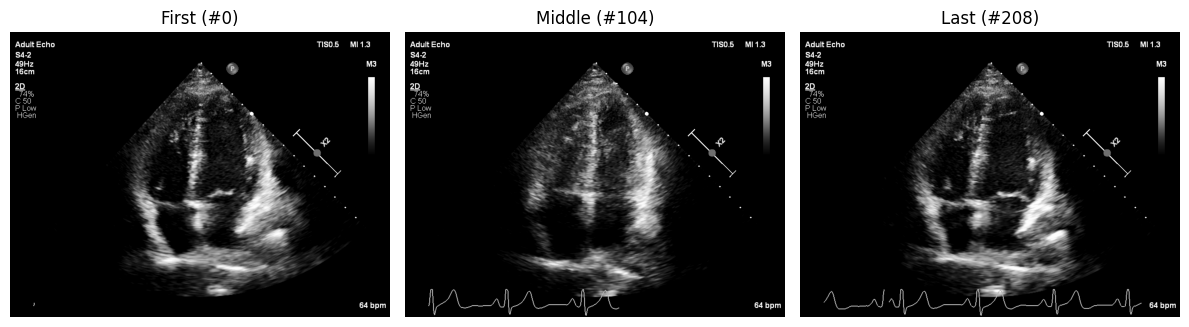

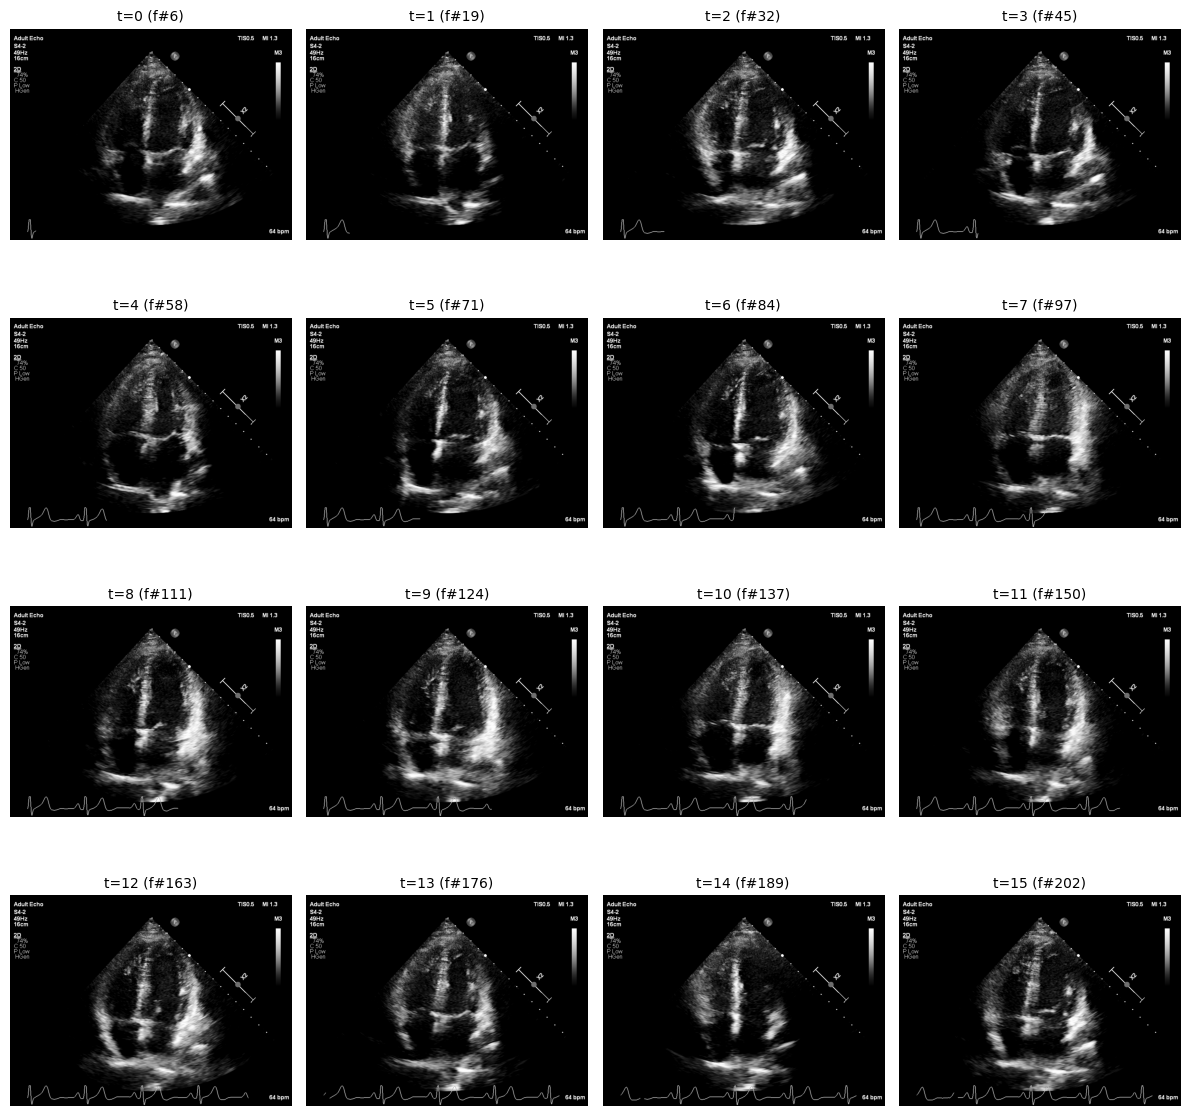

In [ ]:

# Visualize the DICOM cine + model clip

import math
import matplotlib.pyplot as plt
from IPython.display import HTML

# 1) Show first / middle / last frames
plt.figure(figsize=(12,4))
idxs = [0, max(0, frames.shape[0]//2), frames.shape[0]-1]
titles = ["First", "Middle", "Last"]
for i, (idx, ttl) in enumerate(zip(idxs, titles), 1):
    plt.subplot(1,3,i)
    plt.imshow(frames[idx], cmap='gray')
    plt.title(f"{ttl} (#{idx})")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2) Montage of the EXACT frames sampled for the model
sample_idx = uniform_sample_indices(frames.shape[0], CLIP_LEN)
sampled = frames[sample_idx]  # (t, H, W)
rows = math.ceil(sampled.shape[0] / 4)
cols = min(4, sampled.shape[0])
plt.figure(figsize=(12, 3*rows))
for i in range(sampled.shape[0]):
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(sampled[i], cmap='gray')
    ax.set_title(f"t={i} (f#{sample_idx[i]})", fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

# 3) Save & display an MP4 of the cine (full sequence)
out_path = "/content/echo_clip.mp4"
h, w = frames.shape[1], frames.shape[2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(out_path, fourcc, 30, (w, h), isColor=True)
for f in frames:
    writer.write(cv2.cvtColor(f, cv2.COLOR_GRAY2BGR))  # convert to 3-ch for mp4
writer.release()

HTML(f'<video controls loop playsinline width="512" src="{out_path}"></video>')
